# Solving CIFAR 10 using Keras (Work in progress)

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

This notebook attempts to classify those images.

In [1]:
# Import all modules
import time
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
#from keras_sequential_ascii import sequential_model_to_ascii_printout
from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("th")

# Import Tensorflow with multiprocessing
import tensorflow as tf
import multiprocessing as mp
 
# Loading the CIFAR-10 datasets
from keras.datasets import cifar10

Using TensorFlow backend.


In [2]:
#Declaring Variables
batch_size = 32 #Smaller Batch size means more updates in one epoch

num_classes = 10 
epochs = 100 #Repeat 100 times

In [3]:
#Load the Dataset 
(x_train, y_train), (x_test,y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 16s 0us/step


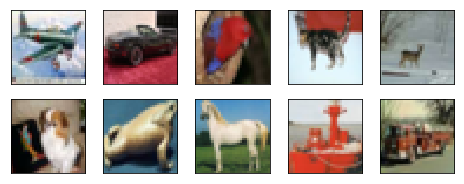

In [4]:
# Print 10 random images 
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2,5,1 + i, xticks=[],yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = np.transpose(features_idx[img_num,::],(1,2,0))
    #ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

We now need to normalize the pixel values. This means to turn them from in the range of 0-255 to be between 0 and 1. 

In [5]:
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train  /= 255
x_test /= 255

In [ ]:
#Defining our model 
def base_model():
    model = Sequential()
    model.add(Conv2D(32,(3,3), padding='same', input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32,(3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(521))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    sgd = SGD(lr = 0.1, decay=1e-6, momentum=0.9, nesterov=True)
    
    #Train model
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

cnn_n = base_model()
cnn_n.summary()
 
#Fit model
 
cnn = cnn_n.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test,y_test),shuffle=True)     
    

# 6 Layer Model
We will now create a 6 layer model to compare with the 4 layer model created above. 

In [ ]:
def six_layer():
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=x_train.shape[1:]))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(32,(3,3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1024,activation='relu',kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    
    sgd = SGD(lr = 0.1, decay=1e-6, momentum=0.9, nesterov=True)
    
    # Train model
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model
cnn_n6 = six_layer()
cnn_n6.summary()
 
# Fit model
 
cnn6 = cnn_n6.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test,y_test),shuffle=True)

# Plotting our accuracy and loss

# 4 Layer CNN

In [ ]:
plt.figure(0)
plt.plot(cnn.history['acc'],'r')
plt.plot(cnn.history['val_acc'],'g')
plt.plot()

In [ ]:
scores = cnn_n.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

# 6 Layer CNN

In [ ]:
plt.figure(1)
plt.plot(cnn6.history['acc'],'r')
plt.plot(cnn6.history['val_acc'],'g')
plt.plot()

In [ ]:
scores = cnn_n6.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

# Confusion Matrix for 4 layer

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = cnn_n.predict(x_test, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)
 
for ix in range(10):
    print(ix, confusion_matrix(np.argmax(y_test,axis=1),y_pred)[ix].sum())
cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
print(cm)
 
# Visualizing of confusion matrix
import seaborn as sn
import pandas  as pd

df_cm = pd.DataFrame(cm, range(10),range(10))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
plt.show()

# Confustion Matrix for 6 layer 

In [ ]:
Y_pred = cnn_n6.predict(x_test, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)
 
for ix in range(10):
    print(ix, confusion_matrix(np.argmax(y_test,axis=1),y_pred)[ix].sum())
cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
print(cm)

df_cm = pd.DataFrame(cm, range(10),range(10))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
plt.show()

# Trying other models 

In [6]:
#Architecture from: https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/
import keras
from keras import regularizers

def new_model():
    weight_decay = 1e-4
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
    
    opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
    return model
new_cnn = new_model() 
new_cnn.summary()
 
# Fit model
cnn4 = new_cnn.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test,y_test),shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 16, 16)        0         
__________

50000/50000 [==============================] - 36s 727us/step - loss: 0.5492 - acc: 0.8856 - val_loss: 0.7008 - val_acc: 0.8441
Epoch 33/100
50000/50000 [==============================] - 36s 729us/step - loss: 0.5465 - acc: 0.8882 - val_loss: 0.7127 - val_acc: 0.8457
Epoch 34/100
50000/50000 [==============================] - 36s 728us/step - loss: 0.5509 - acc: 0.8867 - val_loss: 0.6967 - val_acc: 0.8455
Epoch 35/100
50000/50000 [==============================] - 36s 729us/step - loss: 0.5454 - acc: 0.8901 - val_loss: 0.6893 - val_acc: 0.8493
Epoch 36/100
50000/50000 [==============================] - 36s 728us/step - loss: 0.5478 - acc: 0.8872 - val_loss: 0.6980 - val_acc: 0.8458
Epoch 37/100
50000/50000 [==============================] - 36s 728us/step - loss: 0.5430 - acc: 0.8903 - val_loss: 0.7129 - val_acc: 0.8450
Epoch 38/100
50000/50000 [==============================] - 36s 728us/step - loss: 0.5384 - acc: 0.8906 - val_loss: 0.7607 - val_acc: 0.8328
Epoch 39/100
50000/50000 [

50000/50000 [==============================] - 36s 717us/step - loss: 0.4753 - acc: 0.9166 - val_loss: 0.6977 - val_acc: 0.8560
Epoch 91/100
50000/50000 [==============================] - 36s 717us/step - loss: 0.4826 - acc: 0.9138 - val_loss: 0.7188 - val_acc: 0.8495
Epoch 92/100
50000/50000 [==============================] - 36s 715us/step - loss: 0.4799 - acc: 0.9152 - val_loss: 0.6838 - val_acc: 0.8611
Epoch 93/100
50000/50000 [==============================] - 36s 718us/step - loss: 0.4800 - acc: 0.9158 - val_loss: 0.6869 - val_acc: 0.8557
Epoch 94/100
50000/50000 [==============================] - 36s 720us/step - loss: 0.4787 - acc: 0.9163 - val_loss: 0.7003 - val_acc: 0.8552
Epoch 95/100
50000/50000 [==============================] - 36s 717us/step - loss: 0.4787 - acc: 0.9142 - val_loss: 0.6741 - val_acc: 0.8570
Epoch 96/100
50000/50000 [==============================] - 36s 717us/step - loss: 0.4771 - acc: 0.9156 - val_loss: 0.6977 - val_acc: 0.8560
Epoch 97/100
50000/50000 [

AttributeError: 'History' object has no attribute 'evaluate'

# Looking at the accuracy

In [7]:
scores = new_cnn.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 84.98%


# Saving our model and weight to disk

In [9]:
#save to disk
model_json = new_cnn.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
new_cnn.save_weights('model.h5') 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


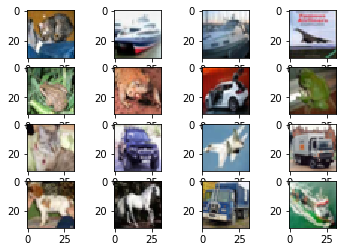

['dog', 'automobile', 'automobile', 'automobile', 'frog', 'frog', 'automobile', 'frog', 'cat', 'automobile', 'airplane', 'truck', 'frog', 'horse', 'truck', 'frog']


In [14]:
from matplotlib import pyplot
from scipy.misc import toimage
from keras.models import model_from_json

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
 
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
 
# mean-std normalization
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

def show_imgs(X):
    pyplot.figure(1)
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            pyplot.subplot2grid((4,4),(i,j))
            pyplot.imshow(toimage(X[k]))
            k = k+1
    # show the plot
    pyplot.show()
    
show_imgs(x_test[:16])
 
# Load trained CNN model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights('model.h5')
 
labels =  ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
 
indices = np.argmax(model.predict(x_test[:16]),1)
print([labels[x] for x in indices])